# MultiMAE: Multi-modal Multi-task Masked Autoencoders



**Important:** This notebook requires a GPU for installing certain dependencies. Let's see which one we got here:

### 1.1 Downgrade PyTorch

In [ ]:
# !pip uninstall -y torch torchvision torchaudio torchtext
# !pip install torch==1.10.0+cu111 torchvision==0.11.0+cu111 torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html

### 1.2 Install dependencies

**Important**: Before running the following cells, please restart the runtime using the menu bar entries `Runtime > Restart runtime`

In [1]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.10 ; cuda:  cu111


In [ ]:
## Install detectron2 that matches the above pytorch version
## See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html

## In case you have troubles with Detectron2, consider installing it from source instead. This takes a few minutes.
#!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
# clone and install Mask2Former
# !git clone https://github.com/facebookresearch/Mask2Former.git
# %cd Mask2Former
# !pip install -U opencv-python
# !pip install git+https://github.com/cocodataset/panopticapi.git
# !pip install -r requirements.txt
# %cd mask2former/modeling/pixel_decoder/ops
# !python setup.py build install
# %cd ../../../../../

In [ ]:
# Clone Dense Prediction Transformer repository
# !git clone https://github.com/isl-org/DPT

In [ ]:
# Clone MultiMAE repository
# !git clone https://github.com/EPFL-VILAB/MultiMAE
# !pip install timm==0.4.12
# !pip install einops==0.3.2

## 2 Imports and model setup

**Important**: Before running the following cells, please restart the runtime **again** using the menu bar entries `Runtime > Restart runtime`

### 2.1 Imports

In [2]:
import sys
sys.path.append("./Mask2Former")
sys.path.append("./DPT")
sys.path.append("./MultiMAE")

# To supress DPT and Mask2Former warnings
import warnings
warnings.filterwarnings("ignore")

import os
from tqdm import tqdm
import random
from functools import partial

In [3]:

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms
from einops import rearrange


In [4]:
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [5]:
# Mask2Former and detectron2 dependencies for semantic segmentation pseudo labeling
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config
coco_metadata = MetadataCatalog.get("coco_2017_val_panoptic")

In [6]:
from mask2former import add_maskformer2_config

In [7]:
# DPT dependencies for depth pseudo labeling
from dpt.models import DPTDepthModel

from multimae.input_adapters import PatchedInputAdapter, SemSegInputAdapter
from multimae.output_adapters import SpatialOutputAdapter
from multimae.multimae import pretrain_multimae_base
from utils.data_constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

torch.set_grad_enabled(False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 2.2 Pseudo labeling model setup

In [ ]:
# Initialize Omnidata depth model

# !wget https://datasets.epfl.ch/vilab/iccv21/weights/omnidata_rgb2depth_dpt_hybrid.pth -P pretrained_models


In [11]:
omnidata_ckpt = torch.load('./pretrained_models/omnidata_rgb2depth_dpt_hybrid.pth', map_location='cpu')
depth_model = DPTDepthModel()
depth_model.load_state_dict(omnidata_ckpt)
depth_model = depth_model.to(device).eval()

def predict_depth(img):
  depth_model_input = (img.unsqueeze(0) - 0.5) / 0.5
  return depth_model(depth_model_input.to(device))

In [15]:
# COCO Mask2Former

cfg = get_cfg()
add_deeplab_config(cfg)
add_maskformer2_config(cfg)
cfg.merge_from_file("./Mask2Former/configs/coco/panoptic-segmentation/swin/maskformer2_swin_small_bs16_50ep.yaml")
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/maskformer/mask2former/coco/panoptic/maskformer2_swin_small_bs16_50ep/model_final_a407fd.pkl'
cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON = True
cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON = True
cfg.MODEL.MASK_FORMER.TEST.PANOPTIC_ON = True
semseg_model = DefaultPredictor(cfg)

def predict_semseg(img):
  return semseg_model(255*img.permute(1,2,0).numpy())['sem_seg'].argmax(0)

def plot_semseg(img, semseg, ax):
  v = Visualizer(img.permute(1,2,0), coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
  semantic_result = v.draw_sem_seg(semseg.cpu()).get_image()
  ax.imshow(semantic_result)

Weight format of MultiScaleMaskedTransformerDecoder have changed! Please upgrade your models. Applying automatic conversion now ...


### 2.3  MultiMAE model setup

In [12]:
DOMAIN_CONF = {
    'rgb': {
        'input_adapter': partial(PatchedInputAdapter, num_channels=3, stride_level=1),
        'output_adapter': partial(SpatialOutputAdapter, num_channels=3, stride_level=1),
    },
    'depth': {
        'input_adapter': partial(PatchedInputAdapter, num_channels=1, stride_level=1),
        'output_adapter': partial(SpatialOutputAdapter, num_channels=1, stride_level=1),
    },
    'semseg': {
        'input_adapter': partial(SemSegInputAdapter, num_classes=133,
                                 dim_class_emb=64, interpolate_class_emb=False, stride_level=4),
        'output_adapter': partial(SpatialOutputAdapter, num_channels=133, stride_level=4),
    },
}
DOMAINS = ['rgb', 'depth', 'semseg']

input_adapters = {
    domain: dinfo['input_adapter'](
        patch_size_full=16,
    )
    for domain, dinfo in DOMAIN_CONF.items()
}
output_adapters = {
    domain: dinfo['output_adapter'](
        patch_size_full=16,
        dim_tokens=256,
        use_task_queries=True,
        depth=2,
        context_tasks=DOMAINS,
        task=domain
    )
    for domain, dinfo in DOMAIN_CONF.items()
}

multimae = pretrain_multimae_base(
    input_adapters=input_adapters,
    output_adapters=output_adapters,
)

CKPT_URL = 'https://github.com/EPFL-VILAB/MultiMAE/releases/download/pretrained-weights/multimae-b_98_rgb+-depth-semseg_1600e_multivit-afff3f8c.pth'
ckpt = torch.hub.load_state_dict_from_url(CKPT_URL, map_location='cpu')
multimae.load_state_dict(ckpt['model'], strict=False)
multimae = multimae.to(device).eval()

### 2.4 Plotting utils

In [13]:
def get_masked_image(img, mask, image_size=224, patch_size=16, mask_value=0.0):
    img_token = rearrange(
        img.detach().cpu(), 
        'b c (nh ph) (nw pw) -> b (nh nw) (c ph pw)', 
        ph=patch_size, pw=patch_size, nh=image_size//patch_size, nw=image_size//patch_size
    )
    img_token[mask.detach().cpu()!=0] = mask_value
    img = rearrange(
        img_token, 
        'b (nh nw) (c ph pw) -> b c (nh ph) (nw pw)', 
        ph=patch_size, pw=patch_size, nh=image_size//patch_size, nw=image_size//patch_size
    )
    return img


def denormalize(img, mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD):
    return TF.normalize(
        img.clone(),
        mean= [-m/s for m, s in zip(mean, std)],
        std= [1/s for s in std]
    )

def plot_semseg_gt(input_dict, ax=None, image_size=224):
    metadata = MetadataCatalog.get("coco_2017_val_panoptic")
    instance_mode = ColorMode.IMAGE
    img_viz = 255 * denormalize(input_dict['rgb'].detach().cpu())[0].permute(1,2,0)
    semseg = F.interpolate(
        input_dict['semseg'].unsqueeze(0).cpu().float(), size=image_size, mode='nearest'
    ).long()[0,0]
    visualizer = Visualizer(img_viz, metadata, instance_mode=instance_mode, scale=1)
    visualizer.draw_sem_seg(semseg)
    if ax is not None:
        ax.imshow(visualizer.get_output().get_image())
    else:
        return visualizer.get_output().get_image()


def plot_semseg_gt_masked(input_dict, mask, ax=None, mask_value=1.0, image_size=224):
    img = plot_semseg_gt(input_dict, image_size=image_size)
    img = torch.LongTensor(img).permute(2,0,1).unsqueeze(0)
    masked_img = get_masked_image(img.float()/255.0, mask, image_size=image_size, patch_size=16, mask_value=mask_value)
    masked_img = masked_img[0].permute(1,2,0)
    
    if ax is not None:
        ax.imshow(masked_img)
    else:
        return masked_img


def get_pred_with_input(gt, pred, mask, image_size=224, patch_size=16):
    gt_token = rearrange(
        gt.detach().cpu(), 
        'b c (nh ph) (nw pw) -> b (nh nw) (c ph pw)', 
        ph=patch_size, pw=patch_size, nh=image_size//patch_size, nw=image_size//patch_size
    )
    pred_token = rearrange(
        pred.detach().cpu(), 
        'b c (nh ph) (nw pw) -> b (nh nw) (c ph pw)', 
        ph=patch_size, pw=patch_size, nh=image_size//patch_size, nw=image_size//patch_size
    )
    pred_token[mask.detach().cpu()==0] = gt_token[mask.detach().cpu()==0]
    img = rearrange(
        pred_token, 
        'b (nh nw) (c ph pw) -> b c (nh ph) (nw pw)', 
        ph=patch_size, pw=patch_size, nh=image_size//patch_size, nw=image_size//patch_size
    )
    return img


def plot_semseg_pred_masked(rgb, semseg_preds, semseg_gt, mask, ax=None, image_size=224):
    metadata = MetadataCatalog.get("coco_2017_val_panoptic")
    instance_mode = ColorMode.IMAGE
    img_viz = 255 * denormalize(rgb.detach().cpu())[0].permute(1,2,0)
    
    semseg = get_pred_with_input(
        semseg_gt.unsqueeze(1), 
        semseg_preds.argmax(1).unsqueeze(1), 
        mask, 
        image_size=image_size//4, 
        patch_size=4
    )
    
    semseg = F.interpolate(semseg.float(), size=image_size, mode='nearest')[0,0].long()

    visualizer = Visualizer(img_viz, metadata, instance_mode=instance_mode, scale=1)
    visualizer.draw_sem_seg(semseg)
    if ax is not None:
        ax.imshow(visualizer.get_output().get_image())
    else:
        return visualizer.get_output().get_image()

def plot_predictions(input_disct, preds, masks, image_size=224):

    masked_rgb = get_masked_image(
        denormalize(input_dict['rgb']), 
        masks['rgb'],
        image_size=image_size,
        mask_value=1.0
    )[0].permute(1,2,0).detach().cpu()
    masked_depth = get_masked_image(
        input_dict['depth'], 
        masks['depth'],
        image_size=image_size,
        mask_value=np.nan
    )[0,0].detach().cpu()

    pred_rgb = denormalize(preds['rgb'])[0].permute(1,2,0).clamp(0,1)
    pred_depth = preds['depth'][0,0].detach().cpu()

    pred_rgb2 = get_pred_with_input(
        denormalize(input_dict['rgb']), 
        denormalize(preds['rgb']).clamp(0,1), 
        masks['rgb'],
        image_size=image_size
    )[0].permute(1,2,0).detach().cpu()
    pred_depth2 = get_pred_with_input(
        input_dict['depth'], 
        preds['depth'], 
        masks['depth'],
        image_size=image_size
    )[0,0].detach().cpu()

    fig = plt.figure(figsize=(10, 10))
    grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0)

    grid[0].imshow(masked_rgb)
    grid[1].imshow(pred_rgb2)
    grid[2].imshow(denormalize(input_dict['rgb'])[0].permute(1,2,0).detach().cpu())

    grid[3].imshow(masked_depth)
    grid[4].imshow(pred_depth2)
    grid[5].imshow(input_dict['depth'][0,0].detach().cpu())

    plot_semseg_gt_masked(input_dict, masks['semseg'], grid[6], mask_value=1.0, image_size=image_size)
    plot_semseg_pred_masked(input_dict['rgb'], preds['semseg'], input_dict['semseg'], masks['semseg'], grid[7], image_size=image_size)
    plot_semseg_gt(input_dict, grid[8], image_size=image_size)

    for ax in grid:
        ax.set_xticks([])
        ax.set_yticks([])
                
    fontsize = 16
    grid[0].set_title('Masked inputs', fontsize=fontsize)
    grid[1].set_title('MultiMAE predictions', fontsize=fontsize)
    grid[2].set_title('Original Reference', fontsize=fontsize)
    grid[0].set_ylabel('RGB', fontsize=fontsize)
    grid[3].set_ylabel('Depth', fontsize=fontsize)
    grid[6].set_ylabel('Semantic', fontsize=fontsize)

    return {
        'rgb_input': masked_rgb,
        'rgb_pred': pred_rgb2,
        'rgb_gt': denormalize(input_dict['rgb'])[0].permute(1,2,0).detach().cpu(),
        'depth_input': masked_depth,
        'depth_pred': pred_depth2,
        'depth_gt': input_dict['depth'][0,0].detach().cpu(),
        'semseg_input': plot_semseg_gt_masked(input_dict, masks['semseg'], mask_value=1.0),
        'semseg_pred': plot_semseg_pred_masked(input_dict['rgb'], preds['semseg'], input_dict['semseg'], masks['semseg']),
        'semseg_gt': plot_semseg_gt(input_dict)
    }

## 3 MultiMAE prediction

Try out MultiMAE by loading any RGB image from a URL using this form:

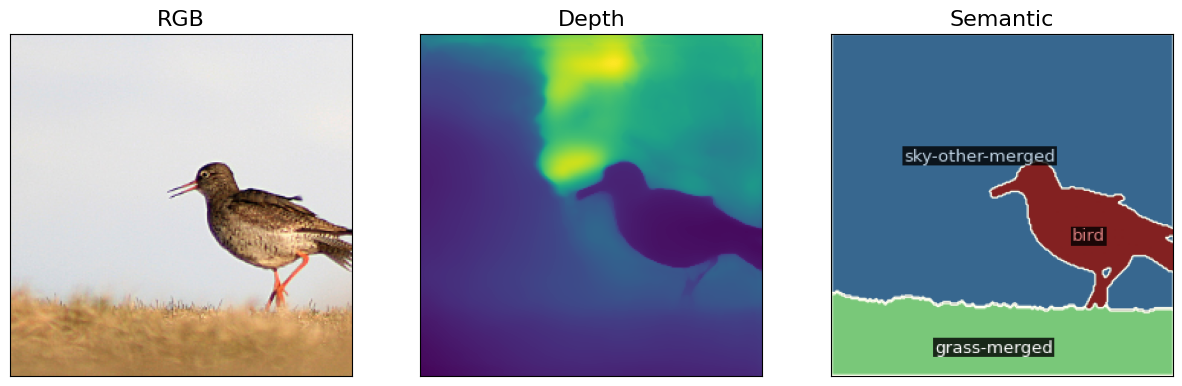

In [23]:
#@title Load image and display pseudo labels

image_url = "https://i.imgur.com/AptRF3J.jpg" #@param {"type": "string"}

# Download image from the specified URL
!wget $image_url -q -O input.jpg
im = Image.open("./datasets/image_net_100/train/rgb/n02028035/n02028035_20.JPEG")

# Center crop and resize RGB
image_size = 224 # Train resolution
img = TF.center_crop(TF.to_tensor(im), min(im.size))
img = TF.resize(img, image_size)

# Predict depth and semseg
depth = predict_depth(img)
semseg = predict_semseg(img)

# Plot loaded RGB image and pseudo labeled depth and semseg
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax[0].imshow(img.permute(1,2,0))
ax[0].set_title('RGB', fontsize=16)
ax[1].imshow(depth[0].cpu())
ax[1].set_title('Depth', fontsize=16)
plot_semseg(img, semseg, ax[2])
ax[2].set_title('Semantic', fontsize=16)

for a in ax:
  a.set_xticks([])
  a.set_yticks([])

plt.show()

In [24]:
# Pre-process RGB, depth and semseg to the MultiMAE input format

input_dict = {}

# Normalize RGB
input_dict['rgb'] = TF.normalize(img, mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD).unsqueeze(0)

# Normalize depth robustly
trunc_depth = torch.sort(depth.flatten())[0]
trunc_depth = trunc_depth[int(0.1 * trunc_depth.shape[0]): int(0.9 * trunc_depth.shape[0])]
depth = (depth - trunc_depth.mean()[None,None,None]) / torch.sqrt(trunc_depth.var()[None,None,None] + 1e-6)
input_dict['depth'] = depth.unsqueeze(0)

# Downsample semantic segmentation
stride = 4
semseg = TF.resize(semseg.unsqueeze(0), (semseg.shape[0] // stride, semseg.shape[1] // stride), interpolation=TF.InterpolationMode.NEAREST)
input_dict['semseg'] = semseg

# To GPU
input_dict = {k: v.to(device) for k,v in input_dict.items()}

Make predictions with a random mask. The mask is sampled during the forward pass and returned, as an output, so you can modify it manually and pass as input (see example below).

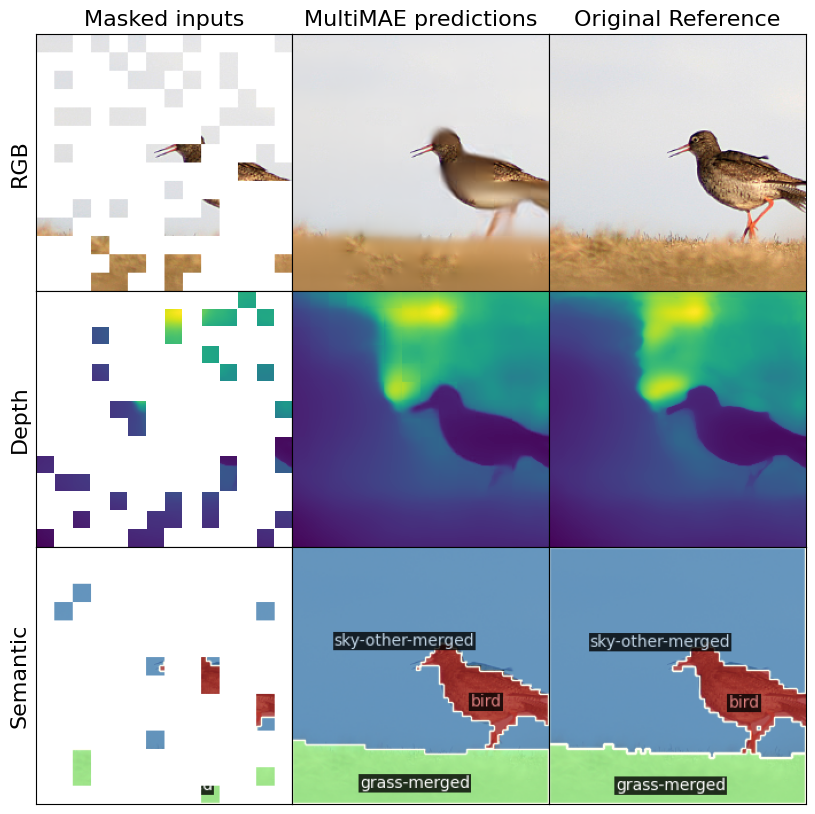

In [25]:
torch.manual_seed(1) # change seed to resample new mask
num_encoded_tokens = 98 # the number of visible tokens
alphas = 1.0 # Dirichlet concentration parameter

preds, masks = multimae.forward(
    input_dict, 
    mask_inputs=True, # True if forward pass should sample random masks
    num_encoded_tokens=num_encoded_tokens,
    alphas=alphas
)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in masks.items()}

res = plot_predictions(input_dict, preds, masks)

You can modify the sampled mask and use it as input. Let us, for example, mask out all the depth and semantic inputs, and only keep the RGB patches.

In [19]:
masks['depth'].fill_(1);
masks['semseg'].fill_(1);

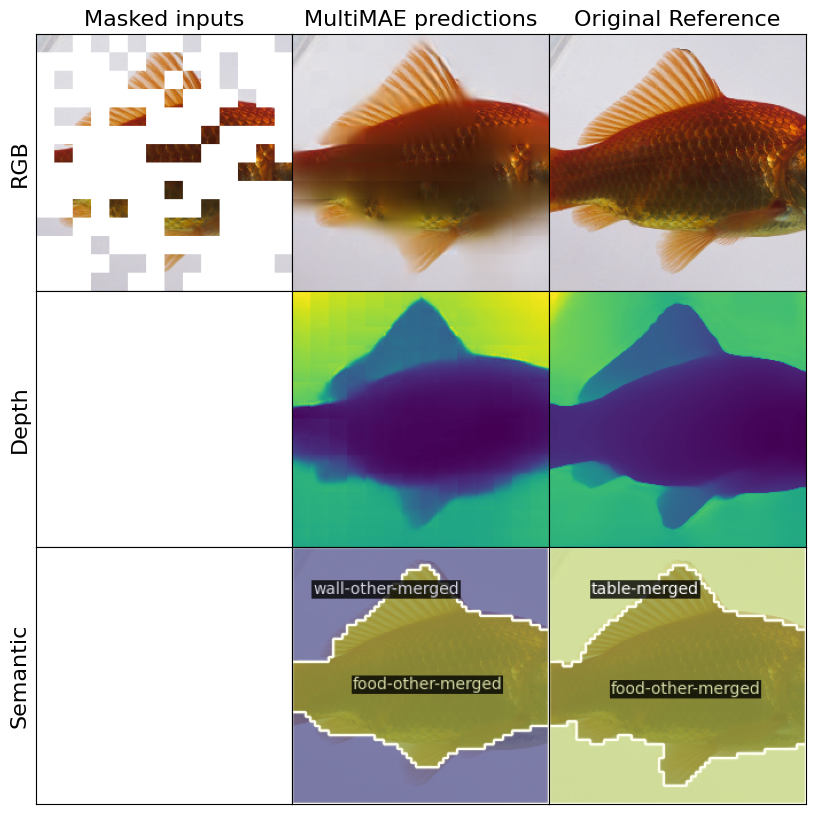

In [20]:
task_masks = {k: v.to(device) for k, v in masks.items()}

preds, masks = multimae.forward(
    input_dict, 
    mask_inputs=True,
    task_masks=task_masks
)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in masks.items()}

res = plot_predictions(input_dict, preds, masks)

You can also define the mask yourself

* 1 - masked patch
* 0 - non-masked

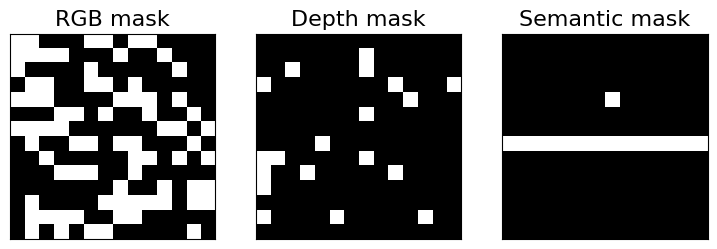

In [21]:
mask = {}

mask['rgb'] = np.array([
    [0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1],
    [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
    [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
    [1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
    [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1],
    [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0],
    [1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1],
    [1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
    [1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0],
    [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0],
    [1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1],
    [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]
])


mask['depth'] = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
])

mask['semseg'] = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
])

plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.imshow(1-mask['rgb'], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('RGB mask', size=16)

plt.subplot(1, 3, 2)
plt.imshow(1-mask['depth'], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Depth mask', size=16)

plt.subplot(1, 3, 3)
plt.imshow(1-mask['semseg'], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Semantic mask', size=16);



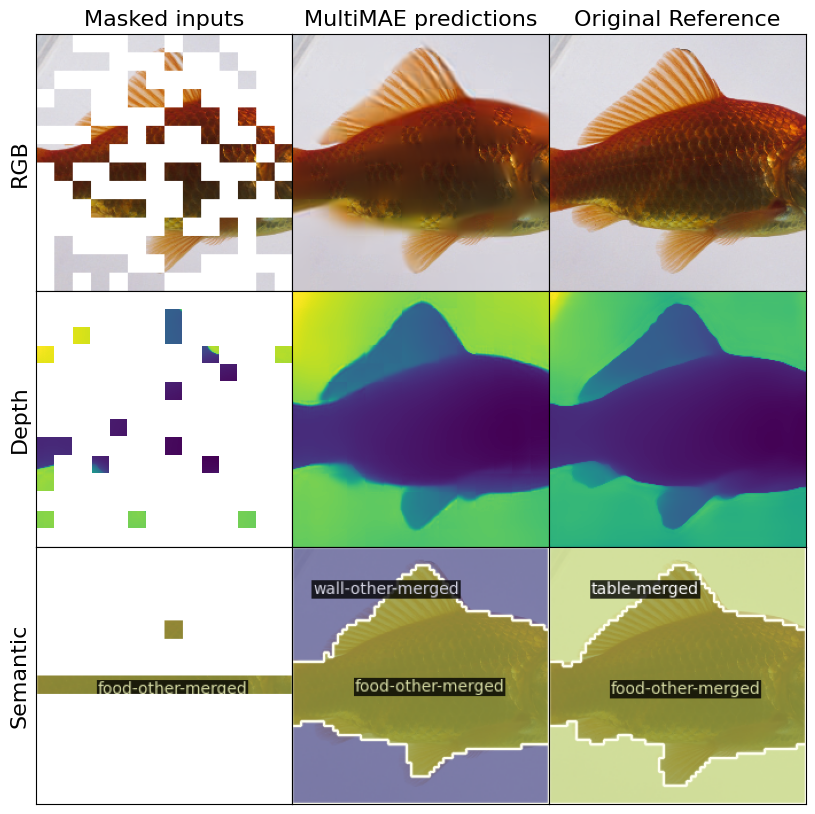

In [22]:
task_masks = {k: torch.LongTensor(v).flatten()[None].to(device) for k, v in mask.items()}
preds, masks = multimae.forward(
    input_dict, 
    mask_inputs=True,
    task_masks=task_masks
)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in masks.items()}

res = plot_predictions(input_dict, preds, masks)